In [1]:
import urllib.request, io, zipfile
import pandas as pd
import numpy as np

def read_data():
  url = 'https://archive.ics.uci.edu/static/public/352/online+retail.zip'
  remotezip = urllib.request.urlopen(url)
  zipinmemory = io.BytesIO(remotezip.read())
  zip = zipfile.ZipFile(zipinmemory)
  for fn in zip.namelist():
      if fn.endswith('xlsx'):
        df =  pd.read_excel(zip.read(fn))
        print(f'Successfully read {len(df)} rows from {fn} at {url}.')
        return df

df = read_data()

Successfully read 541909 rows from Online Retail.xlsx at https://archive.ics.uci.edu/static/public/352/online+retail.zip.


In [2]:
# InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
# StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
# Description: Product (item) name. Nominal.
# Quantity: The quantities of each product (item) per transaction. Numeric.
# InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
# UnitPrice: Unit price. Numeric, Product price per unit in sterling.
# CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
# Country: Country name. Nominal, the name of the country where each customer resides.


#add cancelled flag
df['Cancelled'] = df.apply (lambda row: str(row["InvoiceNo"]).startswith('C') , axis=1)

#total sales
sales = df.Quantity * df.UnitPrice
df['Sales'] = sales.where(df.Cancelled != True, other=0)

# Save the initial DataFrame to a CSV file
df.to_csv('initial_data.csv', index=False)

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34


## Question 1:   
We plan to invite our 50 best customers to a party. Who are they based on the data?



In [3]:
def get_total_sales(df:pd.DataFrame) -> pd.Series:
    """
    Measure the total revenue generated by each customer
    Args:
        df (pd.DataFrame): data
    Returns:
        pd.Series: Total sales with respect to each customer
    """
    return df.groupby(['CustomerID'])['Sales'].sum().sort_index()


def order_frequency(df:pd.DataFrame) -> pd.Series:
    """
    Measure how often a customer makes a purchase.
    Args:
        df (pd.DataFrame): data

    Returns:
        pd.Series: Series with number of orders of customers
    """

    return df.groupby(['CustomerID'])['InvoiceNo'].nunique().sort_index()

def get_best_customers() -> list:
    """
     Calculate the retention rate for each customer
    Returns:
        list: list of top 50 customers
    """
    # Drop nan values
    clean_df = df.dropna()
    # Remove cancelled invoices
    clean_df.drop(clean_df[clean_df.Cancelled == True].index, inplace=True)
    total_sales = get_total_sales(clean_df)
    no_orders = order_frequency(clean_df)
    values = total_sales*no_orders
    return values.sort_values(ascending=False).head(50).index.values.tolist()

top_customers =get_best_customers()
print("The top 50 customers to invite to the party are: ")
print(pd.DataFrame(data=top_customers,columns=["TopCustomerID"]))

The top 50 customers to invite to the party are: 
    TopCustomerID
0         14911.0
1         14646.0
2         18102.0
3         17450.0
4         12748.0
5         14156.0
6         13089.0
7         15311.0
8         16029.0
9         17841.0
10        13694.0
11        17511.0
12        17949.0
13        12415.0
14        15061.0
15        14298.0
16        13798.0
17        16684.0
18        16422.0
19        16013.0
20        13408.0
21        15769.0
22        14606.0
23        14096.0
24        17389.0
25        12971.0
26        15039.0
27        13777.0
28        13098.0
29        15189.0
30        14088.0
31        15838.0
32        13767.0
33        17675.0
34        12931.0
35        17857.0
36        12921.0
37        12471.0
38        17381.0
39        16333.0
40        16839.0
41        15159.0
42        12901.0
43        17677.0
44        17428.0
45        16133.0
46        17404.0
47        14527.0
48        14680.0
49        15856.0


<ipython-input-3-d3a4c38b6fef>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.drop(clean_df[clean_df.Cancelled == True].index, inplace=True)


## Question 2:
Some products like e.g. a body lotion will be used up after some time and the customer needs to buy a new one. The business wants to send follow-up communication to remind customers to replenish certain products.

Your task is to quickly check if the available data supports the described business case:

*   What are the 5 products with the highest re-purchase rate (i.e. being bought by the same customer muliple times)?
*   What is the usual repurchase frequency for a certain product?

In [4]:
pd.set_option('display.max_rows', None)
# len(df)
counts = df.groupby(['StockCode'])['CustomerID'].value_counts()

In [5]:
repurchase_rate = {}
count=0
for i, val in counts.items():
    if i[0] not in repurchase_rate.keys():
        repurchase_rate[i[0]] = {"repurchase":0}

    if val > 1: #repeat
        repurchase_rate[i[0]]['repurchase'] = repurchase_rate[i[0]]['repurchase']+(val-1) #counting only repeat orders


top_five = list({k: v for k, v in sorted(repurchase_rate.items(), key=lambda item: item[1]['repurchase'],reverse=True)}.keys())[:5]
print("Top 5 products: ",top_five)
print("There repurchase rate: ",[repurchase_rate[prod]['repurchase'] for prod in top_five])


Top 5 products:  ['85123A', '85099B', 22423, 20725, 'POST']
There repurchase rate:  [1219, 1026, 1018, 827, 817]


## Question 3:
In order to efficiently use our marketing budget we want to focus on customers that are likely to churn.


*   Create a cohort analysis showing the development of retention over time


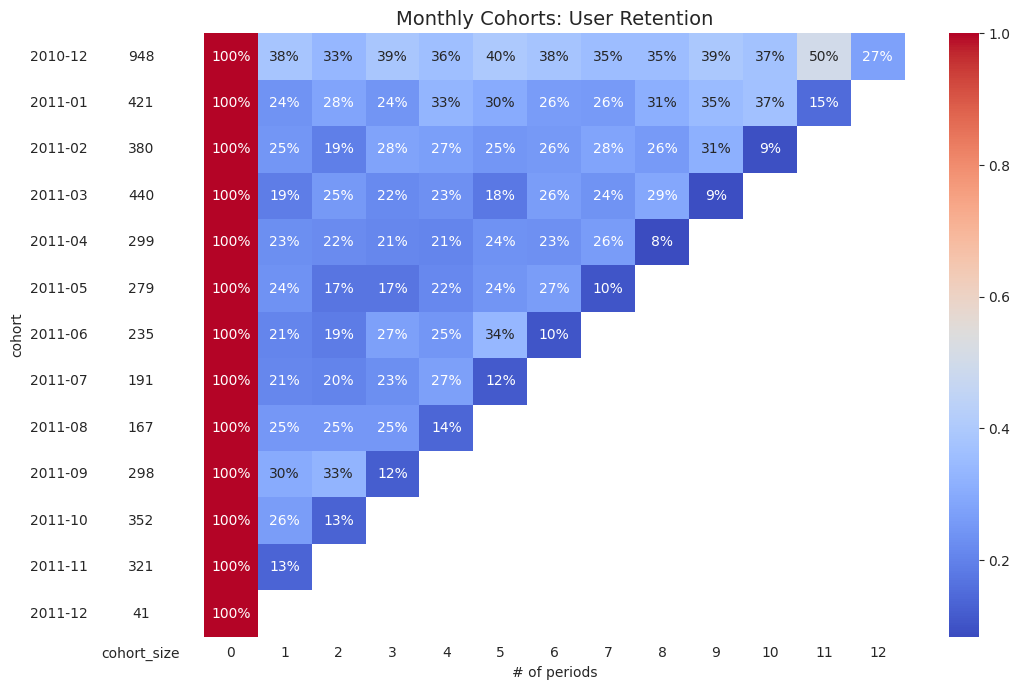

In [6]:
#cohort analysis

df = df[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

df['order_month'] = df['InvoiceDate'].dt.to_period('M')
df['cohort'] = df.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M')

#aggregate the data per cohort and order_month, counting the number of unique customers in each group
df_cohort = df.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)

from operator import attrgetter
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))


cohort_pivot = df_cohort.pivot_table(index = 'cohort', columns = 'period_number', values = 'n_customers')

cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(11, 7), sharey=True, gridspec_kw={'width_ratios': [1, 10]})

    # retention matrix
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.0%',
                cmap='coolwarm',
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=14)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()


## Question 4:
Name 3 business questions that you could explore based on this dataset?

Many questions can be explored based on the dataset. Among them 3 business questions are:

*  Which countries contribute the most to sales?
*  How do sales very in different months?
*  What is the distribution of order sizes or quantities?


